In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from patsy import dmatrix
from numpy.linalg import inv
%matplotlib inline

import statsmodels.api as sm

from scipy import stats

import string

import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, StratifiedShuffleSplit
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree

In [2]:
client_id=''
client_secret=''   
redirect_uri = ''

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_id,
                                                                         client_secret = client_secret))

In [3]:
# to pull all tracks from the requested playlist
def get_playlist(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id= playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [4]:
# to put all information into dicts
def create_data(playlist):   
    data = []
    for i in range(len(playlist)):
        #grabs the specific track id
        trackID = playlist[i]['track']['id']
        # gets audio features of the track
        data_dict = sp.audio_features(trackID)[0]       
        # adding more information track that isn't already there
        data_dict['trackName'] = playlist[i]['track']['name']
        data_dict['artist'] = playlist[i]['track']['artists'][0]['name'] 
        data_dict['album'] = playlist[i]['track']['album']['name']
        
        #now to add the data to the list
        data.append(data_dict)
    
    return data

In [5]:
# pulling the like playlist
username = ''
playlist_url = ''

likedPlaylist = get_playlist(username, playlist_url)

In [6]:
# creating a dataframe for liked
liked_df = pd.DataFrame(create_data(likedPlaylist))
liked_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album
0,0.344,0.610,8,-6.537,1,0.0285,0.059700,0.000000,0.197,0.135,...,audio_features,2JG2OmmwZ5x2RkX0uR5w4k,spotify:track:2JG2OmmwZ5x2RkX0uR5w4k,https://api.spotify.com/v1/tracks/2JG2OmmwZ5x2...,https://api.spotify.com/v1/audio-analysis/2JG2...,247000,4,Wasted Years,Cold,Year Of The Spider
1,0.603,0.707,0,-7.484,1,0.0243,0.422000,0.124000,0.207,0.418,...,audio_features,1SiUYI4mRNCEiTqCfwIR57,spotify:track:1SiUYI4mRNCEiTqCfwIR57,https://api.spotify.com/v1/tracks/1SiUYI4mRNCE...,https://api.spotify.com/v1/audio-analysis/1SiU...,212933,4,Witches,Steaming Satellites,The Moustache Mozart Affaire
2,0.555,0.951,7,-5.297,0,0.0272,0.000058,0.007670,0.318,0.280,...,audio_features,101BaITut2SroBfpBZuFBx,spotify:track:101BaITut2SroBfpBZuFBx,https://api.spotify.com/v1/tracks/101BaITut2Sr...,https://api.spotify.com/v1/audio-analysis/101B...,315280,4,The Hangman's Body Count,Volbeat,Outlaw Gentlemen & Shady Ladies
3,0.566,0.664,4,-5.303,0,0.0464,0.634000,0.000000,0.116,0.437,...,audio_features,1CS7Sd1u5tWkstBhpssyjP,spotify:track:1CS7Sd1u5tWkstBhpssyjP,https://api.spotify.com/v1/tracks/1CS7Sd1u5tWk...,https://api.spotify.com/v1/audio-analysis/1CS7...,241693,4,Take Me to Church,Hozier,Hozier (Expanded Edition)
4,0.489,0.860,7,-6.863,1,0.0725,0.000917,0.000034,0.108,0.370,...,audio_features,4BeG4BJ3mrvarkr4H7nA8i,spotify:track:4BeG4BJ3mrvarkr4H7nA8i,https://api.spotify.com/v1/tracks/4BeG4BJ3mrva...,https://api.spotify.com/v1/audio-analysis/4BeG...,200500,4,Wide Awake,7 Days Away,7 Days Away


In [7]:
liked_df.shape

(457, 21)

In [8]:
# adding the dependent variable
liked_df['liked'] = 1

In [9]:
liked_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album,liked
0,0.344,0.610,8,-6.537,1,0.0285,0.059700,0.000000,0.197,0.135,...,2JG2OmmwZ5x2RkX0uR5w4k,spotify:track:2JG2OmmwZ5x2RkX0uR5w4k,https://api.spotify.com/v1/tracks/2JG2OmmwZ5x2...,https://api.spotify.com/v1/audio-analysis/2JG2...,247000,4,Wasted Years,Cold,Year Of The Spider,1
1,0.603,0.707,0,-7.484,1,0.0243,0.422000,0.124000,0.207,0.418,...,1SiUYI4mRNCEiTqCfwIR57,spotify:track:1SiUYI4mRNCEiTqCfwIR57,https://api.spotify.com/v1/tracks/1SiUYI4mRNCE...,https://api.spotify.com/v1/audio-analysis/1SiU...,212933,4,Witches,Steaming Satellites,The Moustache Mozart Affaire,1
2,0.555,0.951,7,-5.297,0,0.0272,0.000058,0.007670,0.318,0.280,...,101BaITut2SroBfpBZuFBx,spotify:track:101BaITut2SroBfpBZuFBx,https://api.spotify.com/v1/tracks/101BaITut2Sr...,https://api.spotify.com/v1/audio-analysis/101B...,315280,4,The Hangman's Body Count,Volbeat,Outlaw Gentlemen & Shady Ladies,1
3,0.566,0.664,4,-5.303,0,0.0464,0.634000,0.000000,0.116,0.437,...,1CS7Sd1u5tWkstBhpssyjP,spotify:track:1CS7Sd1u5tWkstBhpssyjP,https://api.spotify.com/v1/tracks/1CS7Sd1u5tWk...,https://api.spotify.com/v1/audio-analysis/1CS7...,241693,4,Take Me to Church,Hozier,Hozier (Expanded Edition),1
4,0.489,0.860,7,-6.863,1,0.0725,0.000917,0.000034,0.108,0.370,...,4BeG4BJ3mrvarkr4H7nA8i,spotify:track:4BeG4BJ3mrvarkr4H7nA8i,https://api.spotify.com/v1/tracks/4BeG4BJ3mrva...,https://api.spotify.com/v1/audio-analysis/4BeG...,200500,4,Wide Awake,7 Days Away,7 Days Away,1


In [10]:
# creating the disliked playlist
username = ''
playlist_url = ''
dislikedPlaylist = get_playlist(username, playlist_url)

In [11]:
disliked_df = pd.DataFrame(create_data(dislikedPlaylist))
disliked_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album
0,0.426,0.819,3,-4.893,0,0.0396,0.000662,0.346000,0.113,0.559,...,audio_features,0D7r6CIGNRvs0IvsDOunZr,spotify:track:0D7r6CIGNRvs0IvsDOunZr,https://api.spotify.com/v1/tracks/0D7r6CIGNRvs...,https://api.spotify.com/v1/audio-analysis/0D7r...,240749,4,Irresistible Force,Jane's Addiction,The Great Escape Artist
1,0.545,0.932,0,-2.587,0,0.0580,0.006470,0.000000,0.111,0.198,...,audio_features,47msBbRVaZhujYwSY9mPeu,spotify:track:47msBbRVaZhujYwSY9mPeu,https://api.spotify.com/v1/tracks/47msBbRVaZhu...,https://api.spotify.com/v1/audio-analysis/47ms...,240560,4,Kingdom Of The Blind,Dry Kill Logic,Of Vengeance And Violence
2,0.680,0.763,9,-8.158,1,0.0908,0.004500,0.004620,0.106,0.385,...,audio_features,2yuSLHwPoOoB1zDuXnQnqZ,spotify:track:2yuSLHwPoOoB1zDuXnQnqZ,https://api.spotify.com/v1/tracks/2yuSLHwPoOoB...,https://api.spotify.com/v1/audio-analysis/2yuS...,312720,4,New Noise,Refused,The New Noise Theology EP
3,0.440,0.834,10,-6.655,1,0.0412,0.000018,0.000131,0.284,0.356,...,audio_features,3lUwCryVobacobYrN5f2Je,spotify:track:3lUwCryVobacobYrN5f2Je,https://api.spotify.com/v1/tracks/3lUwCryVobac...,https://api.spotify.com/v1/audio-analysis/3lUw...,302693,4,Switchback,Celldweller,Celldweller (Deluxe Edition)
4,0.557,0.936,0,-4.932,1,0.1100,0.000100,0.397000,0.102,0.394,...,audio_features,05pEwh1SxKNPNwsKoaomXH,spotify:track:05pEwh1SxKNPNwsKoaomXH,https://api.spotify.com/v1/tracks/05pEwh1SxKNP...,https://api.spotify.com/v1/audio-analysis/05pE...,264040,4,Click,Ultraspank,Progress


In [12]:
disliked_df.shape

(152, 21)

In [13]:
# adding dependent variable
disliked_df['liked'] = 0

In [14]:
disliked_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album,liked
0,0.426,0.819,3,-4.893,0,0.0396,0.000662,0.346000,0.113,0.559,...,0D7r6CIGNRvs0IvsDOunZr,spotify:track:0D7r6CIGNRvs0IvsDOunZr,https://api.spotify.com/v1/tracks/0D7r6CIGNRvs...,https://api.spotify.com/v1/audio-analysis/0D7r...,240749,4,Irresistible Force,Jane's Addiction,The Great Escape Artist,0
1,0.545,0.932,0,-2.587,0,0.0580,0.006470,0.000000,0.111,0.198,...,47msBbRVaZhujYwSY9mPeu,spotify:track:47msBbRVaZhujYwSY9mPeu,https://api.spotify.com/v1/tracks/47msBbRVaZhu...,https://api.spotify.com/v1/audio-analysis/47ms...,240560,4,Kingdom Of The Blind,Dry Kill Logic,Of Vengeance And Violence,0
2,0.680,0.763,9,-8.158,1,0.0908,0.004500,0.004620,0.106,0.385,...,2yuSLHwPoOoB1zDuXnQnqZ,spotify:track:2yuSLHwPoOoB1zDuXnQnqZ,https://api.spotify.com/v1/tracks/2yuSLHwPoOoB...,https://api.spotify.com/v1/audio-analysis/2yuS...,312720,4,New Noise,Refused,The New Noise Theology EP,0
3,0.440,0.834,10,-6.655,1,0.0412,0.000018,0.000131,0.284,0.356,...,3lUwCryVobacobYrN5f2Je,spotify:track:3lUwCryVobacobYrN5f2Je,https://api.spotify.com/v1/tracks/3lUwCryVobac...,https://api.spotify.com/v1/audio-analysis/3lUw...,302693,4,Switchback,Celldweller,Celldweller (Deluxe Edition),0
4,0.557,0.936,0,-4.932,1,0.1100,0.000100,0.397000,0.102,0.394,...,05pEwh1SxKNPNwsKoaomXH,spotify:track:05pEwh1SxKNPNwsKoaomXH,https://api.spotify.com/v1/tracks/05pEwh1SxKNP...,https://api.spotify.com/v1/audio-analysis/05pE...,264040,4,Click,Ultraspank,Progress,0


In [15]:
# combining datasets

df = pd.concat([liked_df, disliked_df], ignore_index=True)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album,liked
0,0.344,0.610,8,-6.537,1,0.0285,0.059700,0.000000,0.197,0.135,...,2JG2OmmwZ5x2RkX0uR5w4k,spotify:track:2JG2OmmwZ5x2RkX0uR5w4k,https://api.spotify.com/v1/tracks/2JG2OmmwZ5x2...,https://api.spotify.com/v1/audio-analysis/2JG2...,247000,4,Wasted Years,Cold,Year Of The Spider,1
1,0.603,0.707,0,-7.484,1,0.0243,0.422000,0.124000,0.207,0.418,...,1SiUYI4mRNCEiTqCfwIR57,spotify:track:1SiUYI4mRNCEiTqCfwIR57,https://api.spotify.com/v1/tracks/1SiUYI4mRNCE...,https://api.spotify.com/v1/audio-analysis/1SiU...,212933,4,Witches,Steaming Satellites,The Moustache Mozart Affaire,1
2,0.555,0.951,7,-5.297,0,0.0272,0.000058,0.007670,0.318,0.280,...,101BaITut2SroBfpBZuFBx,spotify:track:101BaITut2SroBfpBZuFBx,https://api.spotify.com/v1/tracks/101BaITut2Sr...,https://api.spotify.com/v1/audio-analysis/101B...,315280,4,The Hangman's Body Count,Volbeat,Outlaw Gentlemen & Shady Ladies,1
3,0.566,0.664,4,-5.303,0,0.0464,0.634000,0.000000,0.116,0.437,...,1CS7Sd1u5tWkstBhpssyjP,spotify:track:1CS7Sd1u5tWkstBhpssyjP,https://api.spotify.com/v1/tracks/1CS7Sd1u5tWk...,https://api.spotify.com/v1/audio-analysis/1CS7...,241693,4,Take Me to Church,Hozier,Hozier (Expanded Edition),1
4,0.489,0.860,7,-6.863,1,0.0725,0.000917,0.000034,0.108,0.370,...,4BeG4BJ3mrvarkr4H7nA8i,spotify:track:4BeG4BJ3mrvarkr4H7nA8i,https://api.spotify.com/v1/tracks/4BeG4BJ3mrva...,https://api.spotify.com/v1/audio-analysis/4BeG...,200500,4,Wide Awake,7 Days Away,7 Days Away,1


In [16]:
# check for duplicate songs across so that one song isn't counted twice
df[df['id'].duplicated(keep='last')]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album,liked
409,0.539,0.732,11,-6.14,1,0.0265,0.000076,0.904,0.109,0.265,...,2HLaosNtdbGMZ1pmOBwFeS,spotify:track:2HLaosNtdbGMZ1pmOBwFeS,https://api.spotify.com/v1/tracks/2HLaosNtdbGM...,https://api.spotify.com/v1/audio-analysis/2HLa...,216107,4,The Otherside,Red Sun Rising,Polyester Zeal,1


In [17]:
# these are the only duplicate song
df[df['id'] == '2HLaosNtdbGMZ1pmOBwFeS']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artist,album,liked
409,0.539,0.732,11,-6.14,1,0.0265,0.000076,0.904,0.109,0.265,...,2HLaosNtdbGMZ1pmOBwFeS,spotify:track:2HLaosNtdbGMZ1pmOBwFeS,https://api.spotify.com/v1/tracks/2HLaosNtdbGM...,https://api.spotify.com/v1/audio-analysis/2HLa...,216107,4,The Otherside,Red Sun Rising,Polyester Zeal,1
608,0.539,0.732,11,-6.14,1,0.0265,0.000076,0.904,0.109,0.265,...,2HLaosNtdbGMZ1pmOBwFeS,spotify:track:2HLaosNtdbGMZ1pmOBwFeS,https://api.spotify.com/v1/tracks/2HLaosNtdbGM...,https://api.spotify.com/v1/audio-analysis/2HLa...,216107,4,The Otherside,Red Sun Rising,Polyester Zeal,0


In [18]:
df.shape

(609, 22)

In [19]:
# removing both rows since it's unsure whether or not it's currently liked or disliked
df = df.drop([409, 608])
df = df.reset_index()
df.shape

(607, 23)

In [20]:
df = df.reset_index()

In [21]:
data_df = df[['danceability', 'energy', 'loudness', 
        'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'valence', 'tempo', 'duration_ms', 'liked']].copy()

In [22]:
# checking for missing values
data_df.isnull().sum()

danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
liked               0
dtype: int64

## EDA

### Boxplots

<AxesSubplot:>

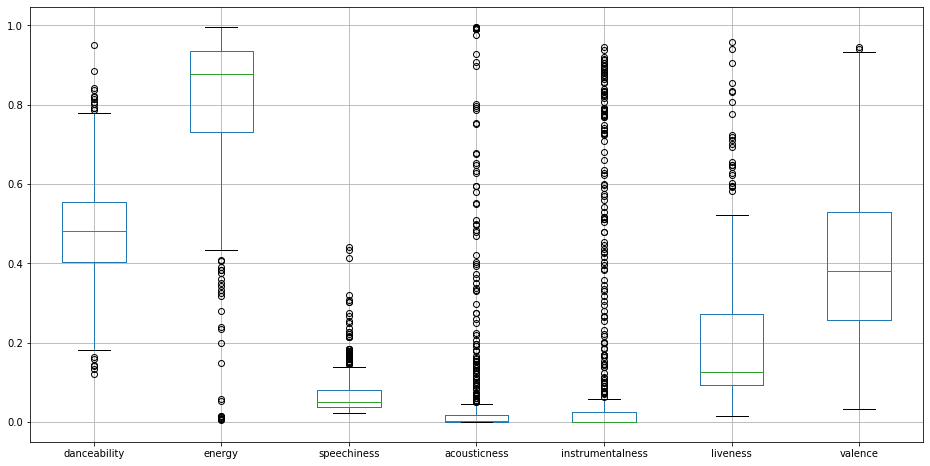

In [23]:
data_df.drop(['duration_ms', 'tempo', 'loudness', 'liked'], axis = 1).boxplot(figsize=(16, 8))

In [24]:
# drop acousticness and instrumentalness since they have so many outliers
data_df = data_df.drop(['acousticness', 'instrumentalness'], axis = 1)

<AxesSubplot:>

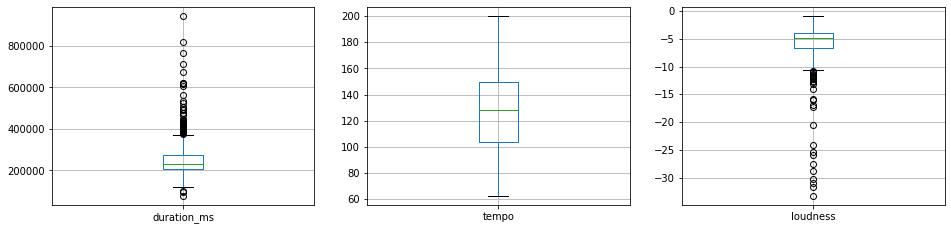

In [25]:
# now the boxplots for each of the other 3 variables
plt.figure(figsize=(16,8))

plt.subplot(2, 3, 1)
data_df[['duration_ms']].boxplot()

plt.subplot(2, 3, 2)
data_df[['tempo']].boxplot()

plt.subplot(2, 3, 3)
data_df[['loudness']].boxplot()

In [26]:
# before removing outliers
len(data_df)

607

In [27]:
# now to remove outliers from data
for i in range(len(data_df.columns)-1):
    Q3 = np.quantile(data_df[data_df.columns[i]], 0.75)
    Q1 = np.quantile(data_df[data_df.columns[i]], 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5*IQR
    upper_range = Q3 + 1.5*IQR
    
    data_df = data_df[data_df[data_df.columns[i]] < upper_range]
    data_df = data_df[data_df[data_df.columns[i]] > lower_range]   

In [28]:
# after removing outliers
len(data_df)

443

<AxesSubplot:>

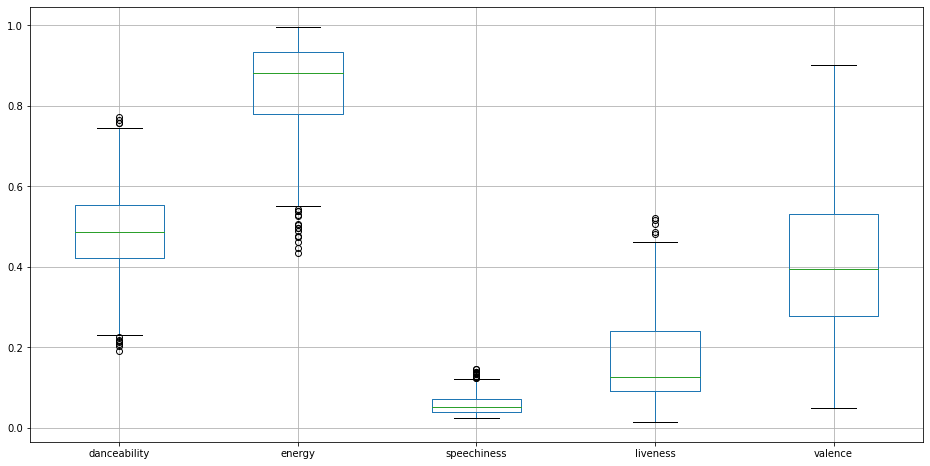

In [29]:
# rechecking boxplots
data_df.drop(['duration_ms', 'tempo', 'loudness', 'liked'], axis = 1).boxplot(figsize=(16, 8))

<AxesSubplot:>

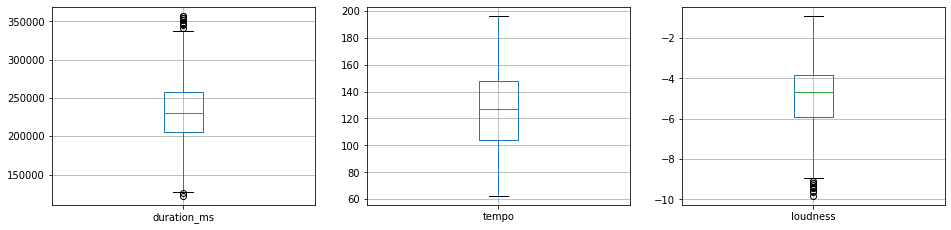

In [30]:
plt.figure(figsize=(16,8))

plt.subplot(2, 3, 1)
data_df[['duration_ms']].boxplot()

plt.subplot(2, 3, 2)
data_df[['tempo']].boxplot()

plt.subplot(2, 3, 3)
data_df[['loudness']].boxplot()

In [31]:
data_df.describe()

,danceability,energy,loudness,speechiness,liveness,valence,tempo,duration_ms,liked
count,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000
mean,0.487102,0.843916,-4.995246,0.059535,0.170221,0.409709,127.641377,233515.230248,0.722348
std,0.109323,0.121288,1.592689,0.027193,0.109753,0.179454,28.229999,44215.757725,0.448347
min,0.192000,0.434000,-9.825000,0.024000,0.014800,0.050600,62.422000,122067.000000,0.000000
25%,0.423500,0.779500,-5.896500,0.038750,0.091500,0.278000,103.861500,205474.500000,0.000000
50%,0.488000,0.883000,-4.670000,0.051300,0.126000,0.394000,126.989000,229640.000000,1.000000
75%,0.555000,0.935000,-3.819000,0.072100,0.240500,0.531500,148.048500,258313.500000,1.000000
max,0.772000,0.997000,-0.912000,0.147000,0.521000,0.901000,196.078000,356627.000000,1.000000


In [32]:
# checking correlation between all variables
corr = data_df.corr()
corr.style.background_gradient(cmap='Greens')

,danceability,energy,loudness,speechiness,liveness,valence,tempo,duration_ms,liked
danceability,1.000000,-0.113820,-0.149473,-0.133831,-0.019196,0.268516,-0.253744,-0.114475,0.089109
energy,-0.113820,1.000000,0.629329,0.390014,0.099760,0.168429,0.091688,-0.124478,-0.182657
loudness,-0.149473,0.629329,1.000000,0.169851,0.070219,0.018294,0.097799,-0.155106,-0.057712
speechiness,-0.133831,0.390014,0.169851,1.000000,0.134301,0.016308,0.201216,-0.150608,-0.116098
liveness,-0.019196,0.099760,0.070219,0.134301,1.000000,-0.018281,-0.086012,-0.051703,-0.001100
valence,0.268516,0.168429,0.018294,0.016308,-0.018281,1.000000,0.034039,-0.254880,-0.083126
tempo,-0.253744,0.091688,0.097799,0.201216,-0.086012,0.034039,1.000000,-0.023056,-0.070192
duration_ms,-0.114475,-0.124478,-0.155106,-0.150608,-0.051703,-0.254880,-0.023056,1.000000,-0.004715
liked,0.089109,-0.182657,-0.057712,-0.116098,-0.001100,-0.083126,-0.070192,-0.004715,1.000000


### Histograms

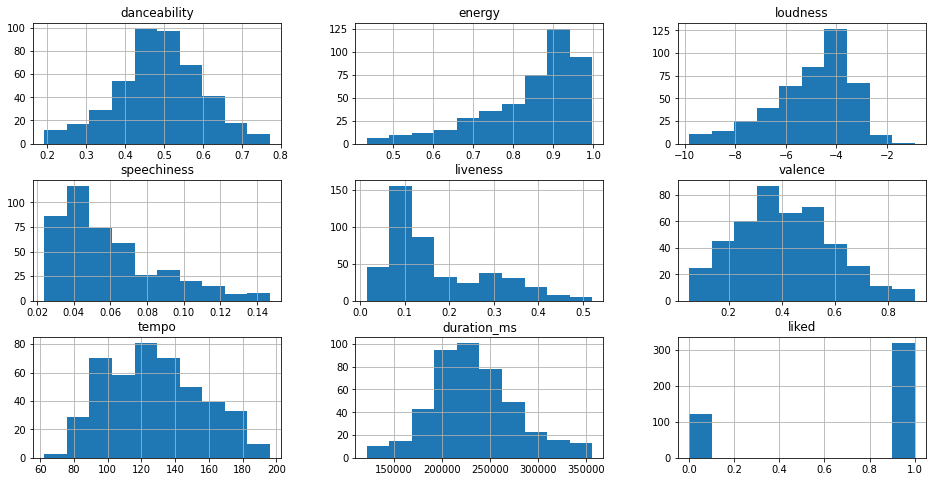

In [33]:
data_df.hist(figsize=(16, 8));

> Danceability, loudness, valence, tempo, and duration_ms all have close to a normal distribution

## KNN Model

In [34]:
# splitting data
X = data_df[['danceability', 'loudness', 
            'speechiness', 'liveness', 'valence', 
             'tempo', 'duration_ms']]
y = data_df['liked']

In [35]:
# scaling all continuous variables
ss = StandardScaler()

X = pd.DataFrame(ss.fit_transform(X), columns= ['danceability', 'loudness', 
                                                'speechiness', 'liveness', 'valence', 
                                                'tempo', 'duration_ms'])
X.head()

,danceability,loudness,speechiness,liveness,valence,tempo,duration_ms
0,-1.310459,-0.969114,-1.142580,0.244270,-1.532541,1.639883,0.305321
1,1.061345,-1.564378,-1.297207,0.335487,0.046251,-1.086646,-0.466022
2,0.621783,-0.189676,-1.190441,1.347995,-0.723620,-0.891633,1.851313
3,0.722516,-0.193448,-0.483571,-0.494587,0.152248,0.046231,0.185161
4,0.017385,-1.174031,0.477330,-0.567561,-0.221530,0.013746,-0.747529


In [36]:
# creating training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [37]:
# using KNN
neigh = KNeighborsClassifier()
k_range = list(range(1, 51))
param_grid = dict(n_neighbors = k_range)

clf = GridSearchCV(neigh, param_grid = param_grid)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 30}

In [38]:
neigh = KNeighborsClassifier(clf.best_params_['n_neighbors'])
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [39]:
# checking overall accuracy
y_pred_train = neigh.predict(X_train)
y_pred = neigh.predict(X_test)
print(f"test accuracy: {metrics.accuracy_score(y_test, y_pred)}, training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")

test accuracy: 0.7142857142857143, training accuracy: 0.7225806451612903


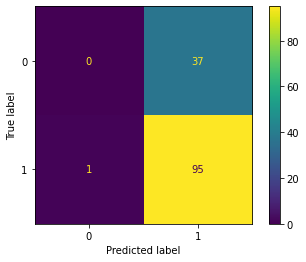

In [40]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels = neigh.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=neigh.classes_)
disp.plot();

C:\Users\reaso\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


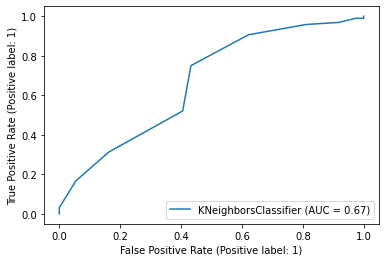

In [41]:
# roc curve
metrics.plot_roc_curve(neigh, X_test, y_test);

## Naive Bayes

In [42]:
X_NB = data_df[['danceability', 'loudness', 
            'speechiness', 'liveness', 'valence', 
             'tempo', 'duration_ms']]
y_NB = data_df['liked']

In [43]:
ss = StandardScaler()

X_NB = pd.DataFrame(ss.fit_transform(X_NB), columns= ['danceability', 'loudness', 
                                                'speechiness', 'liveness', 'valence', 
                                                 'tempo', 'duration_ms'])
X_NB.head()

,danceability,loudness,speechiness,liveness,valence,tempo,duration_ms
0,-1.310459,-0.969114,-1.142580,0.244270,-1.532541,1.639883,0.305321
1,1.061345,-1.564378,-1.297207,0.335487,0.046251,-1.086646,-0.466022
2,0.621783,-0.189676,-1.190441,1.347995,-0.723620,-0.891633,1.851313
3,0.722516,-0.193448,-0.483571,-0.494587,0.152248,0.046231,0.185161
4,0.017385,-1.174031,0.477330,-0.567561,-0.221530,0.013746,-0.747529


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_NB, y_NB, test_size = 0.30, random_state = 42, stratify=y )

In [45]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
y_pred_train = nb.predict(X_train)

print(f"test accuracy: {metrics.accuracy_score(y_test, y_pred)}, training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")

test accuracy: 0.7142857142857143, training accuracy: 0.7193548387096774


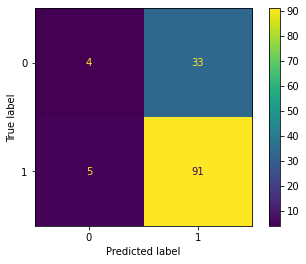

In [46]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels = nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=nb.classes_)
disp.plot();

C:\Users\reaso\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


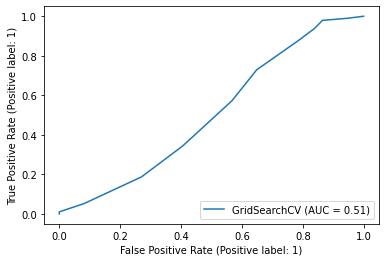

In [47]:
# NB roc curve
metrics.plot_roc_curve(clf, X_test, y_test);